In [113]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics

import matplotlib.pyplot as plt
import altair as alt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [IFT]')
    plt.legend()
    plt.grid(True)
    
def plot_ift(x, y):
    plt.scatter(train_features['Water_content'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Water_content')
    plt.ylabel('IFT')
    plt.legend()


In [83]:
ift_data = pd.read_excel('data/ift_data.xlsx')

In [84]:
# let's explore the data
ift_data.head()

,Gas,Water_content,viscosity,time_minutes,volume_ratio,IFT
0,CH4,0.0,27000.0,0.000050,1.000000,25.08
1,CH4,0.0,27000.0,14.998333,1.002618,25.12
2,CH4,0.0,27000.0,30.000000,1.005236,25.16
3,CH4,0.0,27000.0,45.000000,1.006108,25.17
4,CH4,0.0,27000.0,60.000000,1.007853,25.21


In [85]:
# quick glmipse into the number of rows
ift_data.info

<bound method DataFrame.info of      Gas  Water_content    viscosity  time_minutes  volume_ratio    IFT
0    CH4            0.0   27000.0000      0.000050      1.000000  25.08
1    CH4            0.0   27000.0000     14.998333      1.002618  25.12
2    CH4            0.0   27000.0000     30.000000      1.005236  25.16
3    CH4            0.0   27000.0000     45.000000      1.006108  25.17
4    CH4            0.0   27000.0000     60.000000      1.007853  25.21
..   ...            ...          ...           ...           ...    ...
556  CO2            0.7  236837.0833    150.000000      0.978155  19.93
557  CO2            0.7  236837.0833    165.000000      0.979369  19.95
558  CO2            0.7  236837.0833    180.000000      0.974515  19.87
559  CO2            0.7  236837.0833    195.000000      0.976942  19.92
560  CO2            0.7  236837.0833    210.000000      0.973301  19.86

[561 rows x 6 columns]>

In [86]:
alt.Chart(ift_data, title = 'Change in IFT with water content over time for CH4 and CO2').mark_circle(size=60).encode(
    alt.X('time_minutes:Q', title = 'Time'),
    alt.Y('IFT:Q'),
    alt.Color('Gas:N'),
).interactive()

alt.Chart(...)

In [87]:
alt.Chart(ift_data, title = 'Change in IFT with water content over time for CH4 and CO2').mark_circle(size=60).encode(
    alt.X('Water_content:Q', title = 'Water Content'),
    alt.Y('IFT:Q'),
    alt.Color('Gas:N'),
).interactive()

alt.Chart(...)

In [92]:
x= ift_data.iloc[:,:4] # get x
x

,Gas,Water_content,viscosity,time_minutes
0,CH4,0.0,27000.0000,0.000050
1,CH4,0.0,27000.0000,14.998333
2,CH4,0.0,27000.0000,30.000000
3,CH4,0.0,27000.0000,45.000000
4,CH4,0.0,27000.0000,60.000000
...,...,...,...,...
556,CO2,0.7,236837.0833,150.000000
557,CO2,0.7,236837.0833,165.000000
558,CO2,0.7,236837.0833,180.000000
559,CO2,0.7,236837.0833,195.000000


In [93]:
y = ift_data.iloc[:,5] # get y
y

0      25.08
1      25.12
2      25.16
3      25.17
4      25.21
       ...  
556    19.93
557    19.95
558    19.87
559    19.92
560    19.86
Name: IFT, Length: 561, dtype: float64

In [145]:
# splitting the data into train and test model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)
# since we have numeric and categorical features we will create a column transformer to transform them seperately
X_train

,Gas,Water_content,viscosity,time_minutes
204,CH4,0.33,61030.55556,630.0
558,CO2,0.70,236837.08330,180.0
514,CO2,0.10,35930.00000,915.0
252,CH4,0.45,74375.55556,555.0
164,CH4,0.20,45845.00000,660.0
...,...,...,...,...
98,CH4,0.10,35930.00000,615.0
322,CH4,0.50,86649.44444,780.0
382,CH4,0.70,236837.08330,735.0
365,CH4,0.70,236837.08330,480.0


### Modeling

In [151]:

# first transformer for the numeric features
numeric_features = ['Water_content', 'time_minutes',]  #'viscosity'
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
# now a taransformer for the categorical features
categorical_features = ['Gas']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# creating a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

ridge_model = Ridge()
# include the preprocessor and the model in one pipeline.
# Now we have a full prediction pipeline.
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regressor', ridge_model)])

# finally we will pass the pipe line to gridsearchcv to find the optimum paramters for the model
param_grid = {
    'Regressor__alpha':[0.1,0.25,0.4],
}
search = GridSearchCV(reg_pipeline,param_grid,cv = 5)

# fitting the model
search.fit(X_train, y_train)

# printing the first parameter
print(search.best_params_)
print("model score: %.3f" % search.score(X_test, y_test))


{'Regressor__alpha': 0.4}
model score: 0.515


In [134]:
# let's look at he model paramters
model_intercept = search.best_estimator_['Regressor'].intercept_
model_intercept

22.641914511039513

In [135]:
model_slopes = search.best_estimator_['Regressor'].coef_
model_slopes


array([-0.28426813, -0.15528172,  1.68815898, -1.68815898])

In [136]:
coeff_parameter = pd.DataFrame(search.best_estimator_['Regressor'].coef_,columns=['Coefficient'])
coeff_parameter

,Coefficient
0,-0.284268
1,-0.155282
2,1.688159
3,-1.688159


In [137]:
# let's evaluate the model peroformance using MSE and MAE

In [138]:
y_pred = search.predict(X_test)

In [139]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.0916569015462978
Mean Squared Error: 2.0925408260809752
Root Mean Squared Error: 1.4465617256380645


### Model Selection : Trying Gradient boosting

In [140]:
gb_model = GradientBoostingRegressor()
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regressor', gb_model)])
param_grid = {
    'Regressor__learning_rate':[0.1,0.25,0.4],
}
search = GridSearchCV(reg_pipeline, param_grid, n_jobs=-1)

search.fit(X_train, y_train)
search.best_params_
print("model score: %.3f" % search.score(X_test, y_test))
#reg.get_params().keys()

model score: 0.995


In [141]:
y_pred = search.predict(X_test)

In [142]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 0.07916645077818321
Mean Squared Error: 0.02191124611009874
Root Mean Squared Error: 0.14802447807744076


In [143]:
X_test

,Gas,Water_content,viscosity,time_minutes,true_ift,predicted_ift
466,CO2,0.10,35930.00000,195.0,19.12,19.162117
157,CH4,0.20,45845.00000,555.0,24.38,24.378215
452,CO2,0.00,35930.00000,930.0,23.80,23.893124
449,CO2,0.00,35930.00000,885.0,23.81,23.801766
467,CO2,0.10,35930.00000,210.0,19.09,19.151607
...,...,...,...,...,...,...
508,CO2,0.10,35930.00000,825.0,18.91,18.879700
374,CH4,0.70,236837.08330,615.0,25.08,25.195769
181,CH4,0.20,45845.00000,915.0,24.54,24.530982
485,CO2,0.10,35930.00000,480.0,18.91,18.887714


In [128]:
y_test

466    19.12
157    24.38
452    23.80
449    23.81
467    19.09
       ...  
508    18.91
374    25.08
181    24.54
485    18.91
200    23.85
Name: IFT, Length: 113, dtype: float64

In [129]:
# prediction for one value

In [130]:
new_data = X_test.iloc[[0]]
new_data

,Gas,Water_content,viscosity,time_minutes,true_ift,predicted_ift
466,CO2,0.1,35930.0,195.0,19.12,19.155999


In [131]:
search.predict(new_data)

array([19.162117])

In [132]:
# How predictions compared with the actual results

X_test.loc[:,'true_ift'] = y_test[:]
X_test.loc[:,'predicted_ift'] = y_pred[:]
X_test

,Gas,Water_content,viscosity,time_minutes,true_ift,predicted_ift
466,CO2,0.10,35930.00000,195.0,19.12,19.162117
157,CH4,0.20,45845.00000,555.0,24.38,24.378215
452,CO2,0.00,35930.00000,930.0,23.80,23.893124
449,CO2,0.00,35930.00000,885.0,23.81,23.801766
467,CO2,0.10,35930.00000,210.0,19.09,19.151607
...,...,...,...,...,...,...
508,CO2,0.10,35930.00000,825.0,18.91,18.879700
374,CH4,0.70,236837.08330,615.0,25.08,25.195769
181,CH4,0.20,45845.00000,915.0,24.54,24.530982
485,CO2,0.10,35930.00000,480.0,18.91,18.887714


In [27]:
## saving thee model : 

In [28]:
from joblib import dump, load


dump(search.best_estimator_, 'model.pkl')

['model.pkl']

In [29]:
model1 = load('model.pkl')

model1.predict(new_data)

array([19.93307007])

- The effect of emulsion viscosity: Re run the model with oil viscosity included.

### ANN

In [56]:
## Bulidng simple linear model with one feature: Water Content

In [32]:
ift_data = pd.read_excel('data/ift_data.xlsx')

In [33]:
len(ift_data)

561

In [34]:
X= ift_data[['Water_content']] # get x
y = ift_data.iloc[:,4] # get y

In [35]:
X.head()

,Water_content
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [36]:
y

0      25.08
1      25.12
2      25.16
3      25.17
4      25.21
       ...  
556    19.93
557    19.95
558    19.87
559    19.92
560    19.86
Name: IFT, Length: 561, dtype: float64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

train_features = X_train[['Water_content']]
test_features = X_test[['Water_content']]
normalizer = preprocessing.Normalization()

In [39]:
train_labels = y_train
test_labels = y_test
features = np.array(X_train)
f_normalizer = preprocessing.Normalization(input_shape=[1,])
f_normalizer.adapt(features)
linear_model = tf.keras.Sequential([
    f_normalizer,
    layers.Dense(units=1)
])
linear_model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [41]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')


In [42]:
%%time
history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.56 s, sys: 222 ms, total: 2.78 s
Wall time: 2.47 s


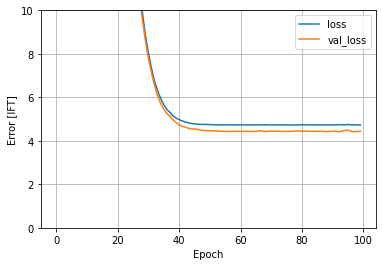

In [43]:
plot_loss(history)

In [45]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.26490592956543}

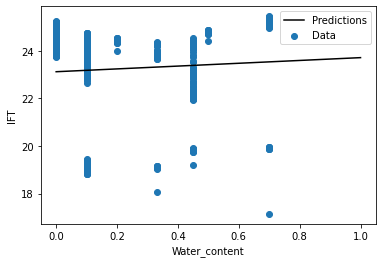

In [46]:
water_content = tf.linspace(0.0, 1, 251)
ift = linear_model.predict(water_content )
plot_ift(water_content,ift)



In [47]:
### Non-linear Model

In [48]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [50]:
dnn_horsepower_model = build_and_compile_model(f_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [51]:
%%time
history = dnn_horsepower_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.7 s, sys: 432 ms, total: 3.13 s
Wall time: 2.26 s


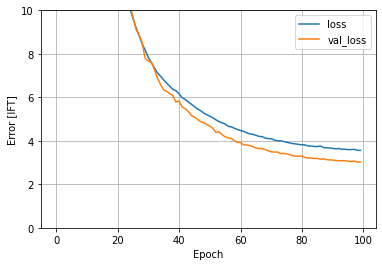

In [52]:
plot_loss(history)

In [53]:
test_results['non_linear'] =dnn_horsepower_model.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.26490592956543, 'non_linear': 3.0177392959594727}

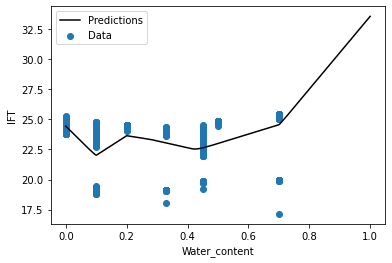

In [54]:
water_content = tf.linspace(0.0, 1, 251)
ift = dnn_horsepower_model.predict(water_content )
plot_ift(water_content, ift)

### Adding More Features:

In [55]:
ift_data = pd.read_excel('data/ift_data.xlsx')
X= ift_data[['Water_content','time_minutes','Gas']] # get x
y = ift_data['IFT'] # get y

X

,Water_content,time_minutes,Gas
0,0.0,0.000050,CH4
1,0.0,14.998333,CH4
2,0.0,30.000000,CH4
3,0.0,45.000000,CH4
4,0.0,60.000000,CH4
...,...,...,...
556,0.7,150.000000,CO2
557,0.7,165.000000,CO2
558,0.7,180.000000,CO2
559,0.7,195.000000,CO2


In [57]:
X = pd.get_dummies(X, prefix='', prefix_sep='')
X.head()

,Water_content,time_minutes,CH4,CO2
0,0.0,0.000050,1,0
1,0.0,14.998333,1,0
2,0.0,30.000000,1,0
3,0.0,45.000000,1,0
4,0.0,60.000000,1,0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
train_features = X_train
test_features = X_test


In [62]:
normalizer = preprocessing.Normalization()
train_labels = y_train
test_labels = y_test
features = np.array(X_train)
ift_normalizer = preprocessing.Normalization(input_shape=[4,])
ift_normalizer.adapt(features)
ift_model = tf.keras.Sequential([
    ift_normalizer,
    layers.Dense(units=1)
])
ift_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________


In [63]:
all_features_model = build_and_compile_model(ift_normalizer)
all_features_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [64]:
%%time
history = all_features_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.66 s, sys: 463 ms, total: 3.13 s
Wall time: 2.19 s


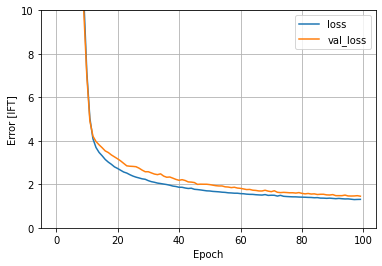

In [65]:
plot_loss(history)

In [66]:
test_results['all_features'] =all_features_model.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.26490592956543,
 'non_linear': 3.0177392959594727,
 'all_features': 1.4632480144500732}

In [68]:
### Deep Learning: The effect of adding more layers to the ANN

In [70]:
def build_and_compile_model_4(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [71]:
def build_and_compile_model_6(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [72]:
def build_and_compile_model_8(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [ ]:
### 4 layers

In [73]:
all_features_model_enhanced = build_and_compile_model_4(ift_normalizer)
all_features_model_enhanced.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 8,714
Trainable params: 8,705
Non-trainable params: 9
_________________________________________________________________


In [74]:
%%time
history = all_features_model_enhanced.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 4min 31s, sys: 58.6 s, total: 5min 30s
Wall time: 3min 26s


In [75]:
test_results['all_features_enhanced'] =all_features_model_enhanced.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.26490592956543,
 'non_linear': 3.0177392959594727,
 'all_features': 1.4632480144500732,
 'all_features_enhanced': 0.05958481878042221}

In [76]:
### 6 Layers: 
all_features_model_enhanced = build_and_compile_model_6(ift_normalizer)
all_features_model_enhanced.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [77]:
%%time
history = all_features_model_enhanced.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 5min 9s, sys: 1min 30s, total: 6min 40s
Wall time: 3min 32s


In [78]:
test_results['all_features_enhanced'] =all_features_model_enhanced.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.26490592956543,
 'non_linear': 3.0177392959594727,
 'all_features': 1.4632480144500732,
 'all_features_enhanced': 0.0692293718457222}

In [79]:
### 8 Layers: 
all_features_model_enhanced = build_and_compile_model_8(ift_normalizer)
all_features_model_enhanced.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 64)               

In [80]:
%%time
history = all_features_model_enhanced.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 5min 51s, sys: 1min 47s, total: 7min 39s
Wall time: 3min 59s


In [81]:
test_results['all_features_enhanced'] =all_features_model_enhanced.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.26490592956543,
 'non_linear': 3.0177392959594727,
 'all_features': 1.4632480144500732,
 'all_features_enhanced': 0.07367828488349915}